# 1D example

Visualization of Gaussian process regression (GPR) using LightGPR on 1D data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LightGPR.gp_reg import gp_reg
from LightGPR.kernels import RQ_kernel, RBF_exp_decay_kernel

Generate some 1D dataset

In [2]:
# Design vector / features
Xtrain_1D = np.random.uniform(0, 10, size=(5,1))

# Target values / labels
ytrain_1D = np.sin(Xtrain_1D).reshape(len(Xtrain_1D))

Create a GPR model and supply the dataset. The default prior mean function is $\mu_{\text{Prior}}(x) = 0$ and the default prior covariance (kernel) function is the RBF kernel.

In [3]:
# 1D prior mean function
prior_mean_func = lambda x: -np.sin(x).reshape(len(x))

# Create GP model
model_1D = gp_reg(Xtrain_1D, ytrain_1D, prior_mean=prior_mean_func)

Train the GPR model. The hyperparameters of the kernel are then optimized via maximum likelihood method.

In [4]:
# Learn hyperparameters
model_1D.train()
print(f"Loss: {model_1D.loss}, Outputscale: {model_1D.outputscale}, "
      f"Kernel hyperparameters: {model_1D.kernel.hyperparams}, "
      f"Noise: {model_1D.ynoise}")

Loss: 7.6098243732615884, Outputscale: 1.205900257907125, Kernel hyperparameters: [0.89972031], Noise: 6.201626204589476e-10


Make predictions with the trained GPR model at test locations `Xtest_1D`. The method `predict(Xtest_1D)` returns the posterior mean (regression) and variance (square of the uncertainty) at the test locations.

In [5]:
# Test points
Xtest_1D = np.linspace(0, 10, 1000)

# Make predictions
mean_post_1D, var_post_1D = model_1D.predict(Xtest_1D)

Plot the results

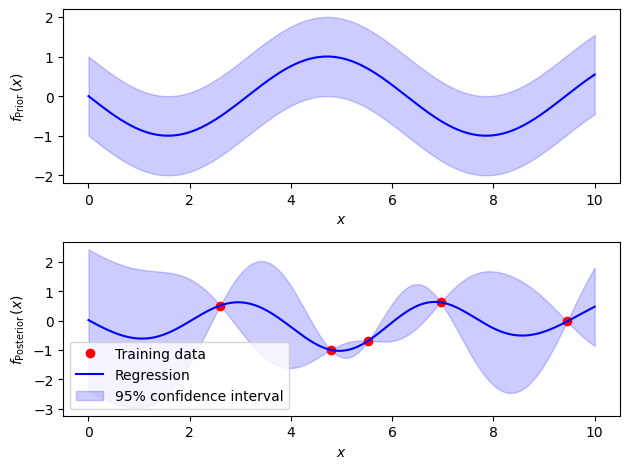

In [6]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(Xtest_1D, prior_mean_func(Xtest_1D), 'b-', label='Prior mean')
ax[0].fill_between(Xtest_1D, 
                   prior_mean_func(Xtest_1D) - 1, 
                   prior_mean_func(Xtest_1D) + 1, 
                   color='b', alpha=0.2)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f_{\text{Prior}} \, (x)$')

ax[1].plot(Xtrain_1D, ytrain_1D, 'ro', label='Training data')
ax[1].plot(Xtest_1D, mean_post_1D, 'b-', label='Regression')
ax[1].fill_between(Xtest_1D, 
                   mean_post_1D - 2*np.sqrt(var_post_1D), 
                   mean_post_1D + 2*np.sqrt(var_post_1D), 
                   color='b', alpha=0.2, label='95% confidence interval')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$f_{\text{Posterior}} \, (x)$')
ax[1].legend()
fig.tight_layout()
plt.show()

# 2D example

Higher-dimensional datasets are treated analogously:

In [7]:
# 2D target function
target_func = lambda x: np.sin(x[:,0]) + np.cos(x[:,1])

# Generate some 2D dataset
Xtrain = np.random.rand(5,2) # Design matrix / features
ytrain = target_func(Xtrain) # Target values / labels

# Create GPR model with RQ kernel
model = gp_reg(Xtrain, ytrain, kernel=RQ_kernel)

# Train GPR model
model.train()
print(f"Loss: {model.loss}, Outputscale: {model.outputscale}, "
      f"Kernel hyperparameters: {model.kernel.hyperparams}, "
      f"Noise: {model.ynoise}")

Loss: -0.1859192260268534, Outputscale: 1.131127933575054, Kernel hyperparameters: [  1.80461596 100.        ], Noise: 1e-10


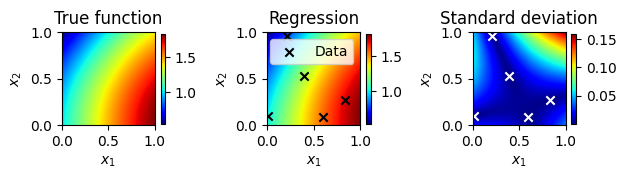

In [8]:
# Make predictions at test points
test_grid = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
Xtest = np.array(list(zip(test_grid[0].ravel(), test_grid[1].ravel())))
mean_post, var_post = model.predict(Xtest)

# Plot results
fig, ax = plt.subplots(1, 3)
im0 = ax[0].imshow(target_func(Xtest).reshape(test_grid[0].shape), 
                   cmap='jet', extent=[0,1,0,1], origin='lower')
fig.colorbar(im0, ax=ax[0], shrink=0.2)
ax[0].set_title('True function')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_xlabel(r'$x_1$')

im1 = ax[1].imshow(mean_post.reshape(test_grid[0].shape), 
                   cmap='jet', extent=[0,1,0,1], origin='lower')
ax[1].scatter(Xtrain[:,0], Xtrain[:,1], c='k', marker='x', label='Data')
fig.colorbar(im1, ax=ax[1], shrink=0.2)
ax[1].set_title('Regression')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_xlabel(r'$x_1$')
ax[1].legend()

im2 = ax[2].imshow(np.sqrt(var_post).reshape(test_grid[0].shape), 
                   cmap='jet', extent=[0,1,0,1], origin='lower')
ax[2].scatter(Xtrain[:,0], Xtrain[:,1], c='w', marker='x', label='Data')
fig.colorbar(im2, ax=ax[2], shrink=0.2)
ax[2].set_title('Standard deviation')
ax[2].set_ylabel(r'$x_2$')
ax[2].set_xlabel(r'$x_1$')
fig.tight_layout()
plt.show()

# Custom kernel functions

A special use case for LightGPR are custom kernel functions, such as non-stationary kernels. These can be added into the `kernel.py` file. Additionally, the existing RBF and RQ kernels can be transformed using the `.kernel.nonstat_fct` attribute, i.e.,
$$ k_{\text{new}}(\mathbf{x}, \mathbf{x}^\prime) = B(\mathbf{x}) \, k(\mathbf{x}, \mathbf{x}^\prime) \, B(\mathbf{x}^\prime) , $$
where `.kernel.nonstat_fct` takes a function defining $B(\mathbf{x})$.

Accordingly, the prior mean function needs to be modified by this function as well:
$$\mu_\text{new} (\mathbf{x}) = B(\mathbf{x}) \mu(\mathbf{x}) .$$

### Box boundaries

As a demonstration, we define a function which is zero at $x_d = L_1$ and $x_d = L_2$ along each dimension $d = 1, 2, \dots, D$:
$$B_{\text{Box}}(\mathbf{x}) = \prod_{d=1}^D \vert x_d - L_1 \vert  \vert x_d - L_2 \vert .$$

In [9]:
def B_box(X, L1=0, L2=1):
    return np.prod(np.abs(X - L1*np.ones(len(X[0]))) 
                   * np.abs(X - L2*np.ones(len(X[0]))), axis=1)

Using this function, we can create a GP which is zero along the edges of a $D$-dimensional box with edge lengths $\Delta L = 1$.

In [10]:
# 2D prior mean function with zero box boundaries
prior_mean_func = lambda x: B_box(x) * (np.sin(x[:,0]) + np.cos(x[:,1]))

# 2D target function
target_func = lambda x: np.sin(2*np.pi*x[:,0]) * np.sin(np.pi*x[:,1])

# Generate some 2D dataset
Xtrain = np.random.rand(5,2) # Design matrix / features
ytrain = target_func(Xtrain) # Target values / labels

# Create GPR model with zero box boundaries
model = gp_reg(Xtrain, ytrain, prior_mean=prior_mean_func)
model.kernel.nonstat_fct = B_box

# Train GPR model
model.train()
print(f"Loss: {model.loss}, Outputscale: {model.outputscale}, "
      f"Kernel hyperparameters: {model.kernel.hyperparams}, "
      f"Noise: {model.ynoise}")

Loss: -6.390019676925391, Outputscale: 47.28419538170739, Kernel hyperparameters: [ 0.72242983 99.99999833], Noise: 0.002106484567944721


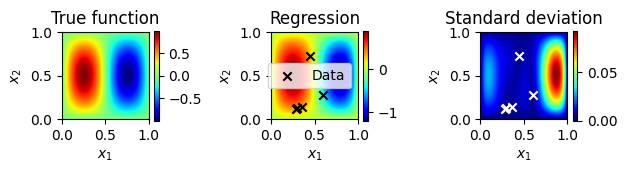

In [11]:
# Make predictions at test points
test_grid = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
Xtest = np.array(list(zip(test_grid[0].ravel(), test_grid[1].ravel())))
mean_post, var_post = model.predict(Xtest)

# Plot results
fig, ax = plt.subplots(1, 3)
im0 = ax[0].imshow(target_func(Xtest).reshape(test_grid[0].shape), 
                   cmap='jet', extent=[0,1,0,1], origin='lower')
fig.colorbar(im0, ax=ax[0], shrink=0.2)
ax[0].set_title('True function')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_xlabel(r'$x_1$')

im1 = ax[1].imshow(mean_post.reshape(test_grid[0].shape), 
                   cmap='jet', extent=[0,1,0,1], origin='lower')
ax[1].scatter(Xtrain[:,0], Xtrain[:,1], c='k', marker='x', label='Data')
fig.colorbar(im1, ax=ax[1], shrink=0.2)
ax[1].set_title('Regression')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_xlabel(r'$x_1$')
ax[1].legend()

im3 = ax[2].imshow(np.sqrt(var_post).reshape(test_grid[0].shape), 
                   cmap='jet', extent=[0,1,0,1], origin='lower')
ax[2].scatter(Xtrain[:,0], Xtrain[:,1], c='w', marker='x', label='Data')
fig.colorbar(im3, ax=ax[2], shrink=0.2)
ax[2].set_title('Standard deviation')
ax[2].set_ylabel(r'$x_2$')
ax[2].set_xlabel(r'$x_1$')
fig.tight_layout()
plt.show()

### Exponential decay

One can create a GP model which exponentially decays as $\vert \mathbf{x} - \mathbf{R}_j \vert \to \infty$. This non-stationary behavior can be implemented by transforming, e.g., a RBF kernel function with 
$$B_{\text{Dec}}(\mathbf{x}) = \prod_j \exp \Bigl( -c \vert \mathbf{x} - \mathbf{R}_j \vert \Bigr) ,$$
with fixed center locations $\mathbf{R}_j$ and a decay rate hyperparameter $c$.

We illustrate the non-stationary GP for a 1D case with two centers located at $R_1 = -1$ and $R_2 = 1$:

In [65]:
# Centers
R1, R2 = -1, 1

# 1D target function
target_func = lambda x: (np.exp(-np.abs(x - R1)) 
                         - np.exp(-np.abs(x - R2))).reshape(len(x))

# Generate some 1D dataset
Xtrain = np.random.uniform(-2, 2, size=(5,1)) # Design matrix / features
ytrain = target_func(Xtrain) # Target values / labels
Xtest = np.linspace(-5, 5, 1000) # Test points

# Create GPR model with decaying RBF kernel and set centers
model = gp_reg(Xtrain, ytrain, kernel=RBF_exp_decay_kernel)
model.kernel.centers = np.array([[R1], [R2]])

# Set boundaries for hyperparameters
model.kernel.bnds_hyperparams = [(1e-1, 1e5), (1e-5, 1e5)]
model.bnds_ynoise = [(1e-10, 1e-6)]

# Compute prior standard deviation for plotting
prior_stdv = np.sqrt(model.kernel.matrix(Xtest, diag=True))

# Train GPR model
model.train()
print(f"Loss: {model.loss}, Outputscale: {model.outputscale}, "
      f"Kernel hyperparameters: {model.kernel.hyperparams}, "
      f"Noise: {model.ynoise}")

Loss: -1.6957442608676416, Outputscale: 5.721994097758628, Kernel hyperparameters: [1.50965602 0.80238274], Noise: 1e-06


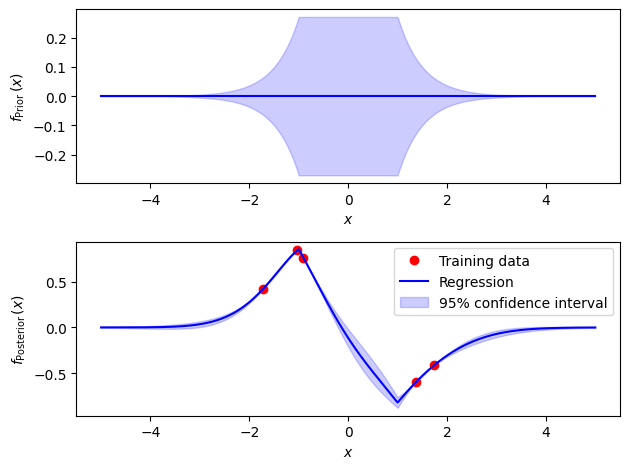

In [66]:
# Make predictions at test points
mean_post, var_post = model.predict(Xtest)

# Plot results
fig, ax = plt.subplots(2, 1)
ax[0].plot(Xtest, np.zeros(len(Xtest)), 'b-')
ax[0].fill_between(Xtest, 
                   np.zeros(len(Xtest)) - 2*prior_stdv, 
                   np.zeros(len(Xtest)) + 2*prior_stdv, 
                   color='b', alpha=0.2)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f_{\text{Prior}} \, (x)$')

ax[1].plot(Xtrain, ytrain, 'ro', label='Training data')
ax[1].plot(Xtest, mean_post, 'b-', label='Regression')
ax[1].fill_between(Xtest, 
                   mean_post - 2*np.sqrt(var_post), 
                   mean_post + 2*np.sqrt(var_post), 
                   color='b', alpha=0.2, label='95% confidence interval')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$f_{\text{Posterior}} \, (x)$')
ax[1].legend()
fig.tight_layout()
plt.show()